In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle
import pandas as pd
import re

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18, Mixed_EqResnet18
from eqCLR.test_resnet import Wide_ResNet
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2026-01-27 10:26:25.934491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-27 10:26:25.998132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-27 10:26:27.300819: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load data and models

## Data

In [3]:
###################### PARAMS ##############################

BACKBONE = "resnet18"

BATCH_SIZE = 512
N_EPOCHS = 100 # 1000
N_CPU_WORKERS = 16
BASE_LR = 0.03         # important
WEIGHT_DECAY = 5e-4    # important
MOMENTUM = 0.9
PROJECTOR_HIDDEN_SIZE = 1024
PROJECTOR_OUTPUT_SIZE = 128
CROP_LOW_SCALE = 0.2
GRAYSCALE_PROB = 0.1   # important
PRINT_EVERY_EPOCHS = 1

In [4]:
###################### DATA LOADER #########################

pmnist_train = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())
pmnist_test = PathMNIST(split='test', download=False, size=28, root='data/pathmnist/', transform=transforms.ToTensor())

print("Data loaded.")

# additional rotation
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

transforms_ssl = transforms.Compose(
    [
        transforms.RandomResizedCrop(size=32, scale=(CROP_LOW_SCALE, 1)),
        # RandomRightAngleRotation(), # additional rotation
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply(
            [transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8
        ),
        transforms.RandomGrayscale(p=GRAYSCALE_PROB),
        transforms.ToTensor(), # NB: runtime faster when this line is last
    ]
)

class PairedTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return (self.transform(x), self.transform(x))


paired_ssl_transforms = PairedTransform(transforms_ssl)

pmnist_train_ssl = PathMNIST(split='train', download=False, size=28, root='data/pathmnist/', transform=paired_ssl_transforms)

pmnist_loader_ssl = DataLoader(
    pmnist_train_ssl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_CPU_WORKERS,
    pin_memory=True,
)

Data loaded.


## Model

In [5]:
class ResNetwithProjector(nn.Module):
    def __init__(self, backbone_network, no_downsampling=False):
        super().__init__()

        self.backbone = backbone_network(weights=None)
        self.backbone_output_dim = self.backbone.fc.in_features

        if no_downsampling:
            self.backbone.conv1 = nn.Conv2d(
                3, 64, kernel_size=3, stride=1, padding=1, bias=False
            )
            self.backbone.maxpool = nn.Identity()
            
        self.backbone.fc = nn.Identity()

        self.projector = nn.Sequential(
            nn.Linear(self.backbone_output_dim, PROJECTOR_HIDDEN_SIZE), 
            nn.ReLU(), 
            nn.Linear(PROJECTOR_HIDDEN_SIZE, PROJECTOR_OUTPUT_SIZE),
        )

    def forward(self, x):
        h = self.backbone(x)
        z = self.projector(h)
        return h, z
    
backbones = {
   "resnet18": resnet18,    # backbone_output_dim = 512
   "resnet34": resnet34,    # backbone_output_dim = 512
   "resnet50": resnet50,    # backbone_output_dim = 2048
}

### Default resnet

In [10]:
# trained with rotations, conv1 having stride=1, without maxpooling
model_resnet18 = ResNetwithProjector(backbones[BACKBONE], no_downsampling=True).to(device)
model_resnet18.load_state_dict(torch.load('results/model_weights/1146-path_mnist-resnet18.pt', weights_only=True))

<All keys matched successfully>

In [9]:
# trained without rotations, conv1 having stride=1, without maxpooling
model_resnet18_wo_rotation = ResNetwithProjector(backbones[BACKBONE], no_downsampling=True).to(device)
model_resnet18_wo_rotation.load_state_dict(torch.load('results/model_weights/7711-path_mnist-resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

In [6]:
# trained with rotations, conv1 having stride=2, with maxpooling
model_resnet18_s2 = ResNetwithProjector(backbones[BACKBONE]).to(device)
model_resnet18_s2.load_state_dict(torch.load('results/model_weights/7117-path_mnist-resnet18_conv1s2_w_maxpool_w_rotation_weights.pt', weights_only=True))

<All keys matched successfully>

### Equivariant models

In [11]:
# default resnet architecture N=4
model_eq = EqResNet18(N=4).to(device)
model_eq.load_state_dict(torch.load('results/model_weights/3957-path_mnist-eqCLR_resnet18_wo_rotation.pt', weights_only=True))

<All keys matched successfully>

In [ ]:
# default resnet architecture N=4 but trained with rotations as augmentations (sanity check)
model_eq_w_rotation = EqResNet18(N=4).to(device)
model_eq_w_rotation.load_state_dict(torch.load('results/model_weights/3943-path_mnist-eqCLR_resnet18_with_rotation.pt', weights_only=True))

In [8]:
# default resnet architecture N=8
model_eq_n8 = EqResNet18(N=8).to(device)
model_eq_n8.load_state_dict(torch.load('results/model_weights/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_weights.pt', weights_only=True))

Make layer
Make layer
Make layer
Make layer


<All keys matched successfully>

In [ ]:
# wide resnet (example escnn)
model_w_res = Wide_ResNet(10, 4, 0.1, initial_stride=1, N=4, f=False, r=0, num_classes=128)
model_w_res.load_state_dict(torch.load('results/model_weights/6072-path_mnist-eqCLR_wide_resnet18_test_weights.pt', weights_only=True))

In [ ]:
# eqResnet N8 with Gaussian blur
# tbd
model_eq_n8_gb = EqResNet18(N=8, projector_hidden_size=1024, n_classes=128, gaussian_blur=True).to(device)
model_eq_n8_gb.load_state_dict(torch.load('_weights.pt', weights_only=True))

In [4]:
# eqResnet N8 with Gaussian blur without downsampling
model_eq_n8_gb_2 = EqResNet18(N=8, projector_hidden_size=1024, n_classes=128, gaussian_blur=True, maxpool=False).to(device)
model_eq_n8_gb_2.load_state_dict(torch.load('results/model_weights/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_weights.pt', weights_only=True))

Make layer
Make layer
Make layer
Make layer


RuntimeError: Error(s) in loading state_dict for EqResNet18:
	Missing key(s) in state_dict: "conv1.0.filter", "conv1.1.bias", "conv1.1.weights", "conv1.1.bias_expansion", "conv1.1.expanded_bias", "conv1.1.filter", "conv1.1._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis". 
	Unexpected key(s) in state_dict: "conv1.bias", "conv1.weights", "conv1.bias_expansion", "conv1.filter", "conv1.expanded_bias", "conv1._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis". 

In [5]:
a = torch.load('results/model_weights/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_weights.pt', weights_only=True)

for key in a.keys():
    print(key, a[key].shape)

conv1.bias torch.Size([64])
conv1.weights torch.Size([3456])
conv1.bias_expansion torch.Size([512, 64])
conv1.filter torch.Size([512, 3, 7, 7])
conv1.expanded_bias torch.Size([512])
conv1._basisexpansion.block_expansion_('irrep_0', 'regular').sampled_basis torch.Size([18, 8, 1, 49])
bn1.indices_8 torch.Size([2])
bn1.batch_norm_[8].weight torch.Size([64])
bn1.batch_norm_[8].bias torch.Size([64])
bn1.batch_norm_[8].running_mean torch.Size([64])
bn1.batch_norm_[8].running_var torch.Size([64])
bn1.batch_norm_[8].num_batches_tracked torch.Size([])
layer1.0.conv1.weights torch.Size([262144])
layer1.0.conv1.filter torch.Size([512, 512, 3, 3])
layer1.0.conv1._basisexpansion.block_expansion_('regular', 'regular').sampled_basis torch.Size([64, 8, 8, 9])
layer1.0.bn1.indices_8 torch.Size([2])
layer1.0.bn1.batch_norm_[8].weight torch.Size([64])
layer1.0.bn1.batch_norm_[8].bias torch.Size([64])
layer1.0.bn1.batch_norm_[8].running_mean torch.Size([64])
layer1.0.bn1.batch_norm_[8].running_var torch.S

In [ ]:
model_eq_n8_gb_2.load_state_dict(torch.load('results/model_weights/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_weights.pt', weights_only=True))

In [ ]:
# Mixed eqResnet (conv1 stride=1, no maxpool)
mixed_eqResnet = Mixed_EqResnet18(resnet18, N=8, projector_hidden_size=PROJECTOR_HIDDEN_SIZE, n_classes=PROJECTOR_OUTPUT_SIZE)
mixed_eqResnet.load_state_dict(torch.load("results/model_weights/3131-path_mnist-mixed_eqCLR_resnet18_N8_weights.pt", weights_only=True))

In [5]:
# eqresnet even kernel
model_eq_even = EqResNet18(N=8, projector_hidden_size=PROJECTOR_HIDDEN_SIZE, n_classes=PROJECTOR_OUTPUT_SIZE).to(device)
model_eq_even.load_state_dict(torch.load(f'results/model_weights/3192-path_mnist-eqCLR_even_kernel_N8_weights.pt'))

Make layer
Make layer
Make layer
Make layer


<All keys matched successfully>

# Evaluation

In [6]:
# SimCLR
with open('results/model_eval/1146-eval_dict_SimCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18 = pickle.load(f)

# SimCLR  without rotation
with open('results/model_eval/7711-eval_dict_SimCLR_wo_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_resnet18_wo_rotation = pickle.load(f)

# SimCLR with downsampling
with open('results/model_eval/7117-path_mnist-resnet18_conv1s2_w_maxpool_w_rotation_eval.pkl', 'rb') as f:
    eval_dict_resnet18_downsampling = pickle.load(f)

# EqCLR
with open('results/model_eval/3957-eval_dict_eqCLR_pathmnist.pkl', 'rb') as f:
    eval_dict_eq = pickle.load(f)

# EqCLR with rotations
with open('results/model_eval/3943-eval_dict_eqCLR_w_rotation_pathmnist.pkl', 'rb') as f:
    eval_dict_eq_w_rotation = pickle.load(f)

# EqCLR N=8
with open('results/model_eval/9521-path_mnist-eqCLR_resnet18_wo_rot_N8_eval.pkl', 'rb') as f:
    eval_dict_eq_n8 = pickle.load(f)

# Wide resnet
with open('results/model_eval/6072-path_mnist-eqCLR_wide_resnet18_test_eval.pkl', 'rb') as f:
    eval_dict_eq_wide_resnet = pickle.load(f)

# EqCLR N8 Gaussian blur
with open('results/model_eval/4407-path_mnist-eqCLR_resnet18_N8_new_downsampling_eval.pkl', 'rb') as f:
    eval_dict_eq_n8_gb = pickle.load(f)

# Mixed EqCLR N8
with open('results/model_eval/3131-path_mnist-mixed_eqCLR_resnet18_N8_eval.pkl', 'rb') as f:
    eval_dict_mixed_eq_n8 = pickle.load(f)

# Even kernel size EqCLR N8
with open('results/model_eval/3192-path_mnist-eqCLR_even_kernel_N8_2_eval.pkl', 'rb') as f:
    eval_dict_even_eq_n8 = pickle.load(f)

# Fully even kernel size N8
with open('results/model_eval/4621-path_mnist-eqCLR_fully_even_kernel_N8_eval.pkl', 'rb') as f:
    eval_dict_f_even_eq_n8 = pickle.load(f)


In [7]:
import pandas as pd

models = {
    "eqResnet18_N8": eval_dict_eq_n8,
    "eqResnet18_f_even_kernel_N8": eval_dict_even_eq_n8,
    # "eqResnet18_N8_gb": eval_dict_eq_n8_gb,
    # "eqResnet18": eval_dict_eq,
    # "eqResnet18_w_rotation": eval_dict_eq_w_rotation,
    "Resnet18": eval_dict_resnet18,
    #"Resnet18_wo_rotation": eval_dict_resnet18_wo_rotation,
    "Resnet18_downsampling": eval_dict_resnet18_downsampling,
    # "WideResnet18": eval_dict_eq_wide_resnet,
    # "Mixed_eqResnet18_N8": eval_dict_mixed_eq_n8,
    }

eval_dict_all = {}

for model in models:
    eval_dict_all[model] = {}
    eval_dict = models[model]
    eval_dict_all[model]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    eval_dict_all[model]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18_N8,0.881755,0.878691,0.895404,0.893733,0.878273
eqResnet18_f_even_kernel_N8,0.797075,0.794847,0.833983,0.833008,NaN
Resnet18,0.853203,0.848329,0.867967,0.863370,0.826323
Resnet18_downsampling,0.793036,0.792201,0.807660,0.808635,0.741086


In [10]:
import pickle
import pandas as pd
from pathlib import Path
import re

# Path to your folder containing all .pkl files
folder_path = Path("results/model_eval")

# Dictionary to hold all loaded pickle files
models = {}

# Load all .pkl files in the folder
for pkl_file in folder_path.glob("*.pkl"):
    # Extract the 4-digit prefix as model name
    match = re.match(r"(\d{4})", pkl_file.stem)
    if match:
        model_name = match.group(1)
    else:
        model_name = pkl_file.stem  # fallback to full name if no 4-digit prefix
    
    with open(pkl_file, 'rb') as f:
        models[model_name] = pickle.load(f)

# Now build eval_dict_all similar to your manual code
eval_dict_all = {}

for model_name, eval_dict in models.items():
    eval_dict_all[model_name] = {}
    
    # KNN entries (if available)
    if 'euclidean' in eval_dict and 10 in eval_dict['euclidean']:
        eval_dict_all[model_name]['KNN (k=10, euclidean)'] = eval_dict['euclidean'][10]
    if 'cosine' in eval_dict and 10 in eval_dict['cosine']:
        eval_dict_all[model_name]['KNN (k=10, cosine)'] = eval_dict['cosine'][10]
    
    # Add other keys
    for key in eval_dict:
        if key not in ["euclidean", "cosine", "linear_accuracy"]:
            eval_dict_all[model_name][key] = eval_dict[key]

# Convert to DataFrame
evals_df = pd.DataFrame(eval_dict_all).T
evals_df = evals_df.sort_values(by='KNN (k=10, euclidean)', ascending=False)

display(evals_df)


,"KNN (k=10, euclidean)","KNN (k=10, cosine)",logistic_regression,linear_accuracy_rep,linear_accuracy_aug
4407,0.900557,0.896797,0.916992,0.918106,0.805989
6072,0.882591,0.884540,0.902507,0.905153,0.690251
9521,0.881755,0.878691,0.895404,0.893733,0.878273
3131,0.877994,0.876045,0.892201,0.890947,0.852368
6289,0.858914,0.861003,0.876323,0.877437,0.831337
7711,0.857521,0.854318,0.862813,0.864763,0.847354
1146,0.853203,0.848329,0.867967,0.863370,0.826323
eval_resnet18_w_rotation,0.853203,0.848329,0.867967,0.851950,0.825627
6675,0.846936,0.845682,0.847075,0.847772,0.831476
9052,0.840808,0.838301,0.857242,0.855710,0.829248


# Equivariance check

It must hold:
\begin{align}
f(Rx) = R(f(x))
\end{align}

In [9]:
import torch
import numpy as np
from escnn.nn import GeometricTensor
from escnn.nn import EquivariantModule

def get_module_device(module):
    # Check parameters
    for p in module.parameters():
        return p.device
    # Check buffers (ESCNN layers often store filters as buffers)
    for b in module.buffers():
        return b.device
    return torch.device("cpu")


def check_equivariance_90deg(self, atol: float = 1e-7, rtol: float = 1e-5):
    """
    Check equivariance for 90-degree rotations.
    Automatically uses the same device as the module.
    """

    # # Determine device
    # params = list(self.parameters())
    # if len(params) > 0:
    #     device = params[0].device
    # else:
    #     # fallback: CPU if no parameters (e.g., for some ESCNN layers)
    #     device = torch.device('cpu')

    device = get_module_device(self)

    # Input tensor
    c = self.in_type.size
    x = torch.randn(3, c, *[10]*self.in_type.gspace.dimensionality, device=device) # random input
    x = GeometricTensor(x, self.in_type)

    errors = {}
    group_elements = self.in_type.gspace.fibergroup.elements
    testing_elements = [g for g in group_elements if np.isclose(g.to('radians') % (np.pi/2), 0)]

    for el in testing_elements:
        # Forward + transform
        out1 = self(x).transform(el).tensor.detach().cpu().numpy()
        out2 = self(x.transform(el)).tensor.detach().cpu().numpy()

        # Compute absolute error
        errs = np.abs(out1 - out2).reshape(-1)

        if not np.allclose(out1, out2, atol=atol, rtol=rtol):
            print(f"⚠ WARNING: Error for element {el}: "
                  f"max={errs.max():.6f}, mean={errs.mean():.6f}, var={errs.var():.6f}")
        
        #errors.append((el, errs.mean()))
        errors[el] = errs.mean()

    return errors

EquivariantModule.check_equivariance_90deg = check_equivariance_90deg


In [11]:
def check_equivariance_torch(self, atol: float = 1e-7, rtol: float = 1e-5):
    """
    Check equivariance for 90-degree rotations.
    Automatically uses the same device as the module.
    """

    params = list(self.parameters())
    device = params[0].device if len(params) > 0 else torch.device('cpu')
    
    if isinstance(self, nn.Conv2d):
        size = (3, self.in_channels, 10, 10)
        # Random input
        x = torch.randn(*size, device=device) 
    # elif isinstance(self, nn.Linear):
    #     size = (3, self.in_features)
    #     # Random input
    #     x = torch.randn(*size, device=device)

        errors = {}
        
        # Rotations to test (multiples of 90°)
        for k, deg in enumerate([0, 90, 180, 270]):
            # Rotate input by k*90 degrees (on last two dims H,W)
            x_rot = torch.rot90(x, k=k, dims=(2,3))
            
            out1 = torch.rot90(self(x).detach().cpu(), k=k, dims=(2,3)).cpu().numpy()
            out2 = self(x_rot).detach().cpu().numpy()

            # Compute error
            errs = np.abs(out1 - out2).reshape(-1)
            errors[deg] = errs.mean()
            
            if not np.allclose(out1, out2, atol=atol, rtol=rtol):
                print(f"⚠ WARNING: Error for element {k}: "
                    f"max={errs.max():.6f}, mean={errs.mean():.6f}, var={errs.var():.6f}")
        return errors
    else:
        pass

nn.Module.check_equivariance_torch = check_equivariance_torch

## Default Resnet

In [12]:
# resnet with stride=1, no maxpool
errors_dict_resnet = {}

for name, module in model_resnet18.named_modules():
    if isinstance(module, nn.Conv2d) :
        print(f"Checking module: {name} ({module.__class__.__name__})")
        errors = module.check_equivariance_torch()
        errors_dict_resnet[name] = errors

Checking module: backbone.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=2.884026, mean=0.297220, var=0.105455
⚠ WARNING: Error for element 2: max=3.903996, mean=0.349420, var=0.159423
⚠ WARNING: Error for element 3: max=3.132452, mean=0.297426, var=0.108339
Checking module: backbone.layer1.0.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=2.550028, mean=0.290606, var=0.066381
⚠ WARNING: Error for element 2: max=3.259884, mean=0.336231, var=0.088392
⚠ WARNING: Error for element 3: max=2.864102, mean=0.291639, var=0.068466
Checking module: backbone.layer1.0.conv2 (Conv2d)
⚠ WARNING: Error for element 1: max=1.751105, mean=0.277560, var=0.050305
⚠ WARNING: Error for element 2: max=2.137530, mean=0.310569, var=0.064291
⚠ WARNING: Error for element 3: max=1.802195, mean=0.278453, var=0.050847
Checking module: backbone.layer1.1.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=1.574426, mean=0.259461, var=0.043966
⚠ WARNING: Error for element 2: max=2.019266, mean=0.281984, var=0.05

In [13]:
errors_df_resnet = pd.DataFrame.from_dict(errors_dict_resnet, orient='index')
errors_df_resnet['mean_error'] = errors_df_resnet.iloc[:,1:].mean(axis=1)
errors_df_resnet = errors_df_resnet[~errors_df_resnet.index.str.contains("downsample")]
display(errors_df_resnet)
# df_sorted = errors_df_resnet.sort_values(by='mean_error', ascending=False)
# display(df_sorted)
# mean per column
print(errors_df_resnet.mean(axis=0))

resnet_layers = errors_df_resnet.index.tolist()
resnet_layers = [name.replace('backbone.', '', 1) for name in resnet_layers]
resnet_layers_means = errors_df_resnet['mean_error'].tolist()
print(resnet_layers)

,0,90,180,270,mean_error
backbone.conv1,0.0,0.297220,0.349420,0.297426,0.314689
backbone.layer1.0.conv1,0.0,0.290606,0.336231,0.291639,0.306159
backbone.layer1.0.conv2,0.0,0.277560,0.310569,0.278453,0.288861
backbone.layer1.1.conv1,0.0,0.259461,0.281984,0.261538,0.267661
backbone.layer1.1.conv2,0.0,0.259878,0.282873,0.257307,0.266686
backbone.layer2.0.conv1,0.0,0.223078,0.241814,0.220012,0.228301
backbone.layer2.0.conv2,0.0,0.235591,0.258021,0.234461,0.242691
backbone.layer2.1.conv1,0.0,0.212685,0.234581,0.211517,0.219594
backbone.layer2.1.conv2,0.0,0.177143,0.200045,0.177165,0.184784
backbone.layer3.0.conv1,0.0,0.151436,0.168227,0.152002,0.157222


0             0.000000
90            0.189955
180           0.210702
270           0.189693
mean_error    0.196783
dtype: float32
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


In [13]:
# resnet with stride=2 and with maxpool
errors_dict_resnet_s2 = {}

for name, module in model_resnet18_s2.named_modules():
    if isinstance(module, nn.Conv2d) :
        print(f"Checking module: {name} ({module.__class__.__name__})")
        errors = module.check_equivariance_torch()
        errors_dict_resnet_s2[name] = errors

Checking module: backbone.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=6.615863, mean=0.606706, var=0.697029
⚠ WARNING: Error for element 2: max=7.351756, mean=0.624546, var=0.695072
⚠ WARNING: Error for element 3: max=6.660828, mean=0.588714, var=0.658831
Checking module: backbone.layer1.0.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=3.047390, mean=0.335140, var=0.096064
⚠ WARNING: Error for element 2: max=3.285564, mean=0.382798, var=0.121329
⚠ WARNING: Error for element 3: max=3.069803, mean=0.340014, var=0.098461
Checking module: backbone.layer1.0.conv2 (Conv2d)
⚠ WARNING: Error for element 1: max=1.936104, mean=0.284918, var=0.060550
⚠ WARNING: Error for element 2: max=3.096231, mean=0.321713, var=0.078340
⚠ WARNING: Error for element 3: max=2.165382, mean=0.286530, var=0.061036
Checking module: backbone.layer1.1.conv1 (Conv2d)
⚠ WARNING: Error for element 1: max=2.575614, mean=0.374001, var=0.097450
⚠ WARNING: Error for element 2: max=2.692137, mean=0.404846, var=0.11

In [14]:
errors_df_resnet_s2 = pd.DataFrame.from_dict(errors_dict_resnet_s2, orient='index')
errors_df_resnet_s2['mean_error'] = errors_df_resnet_s2.iloc[:,1:].mean(axis=1)
errors_df_resnet_s2 = errors_df_resnet_s2[~errors_df_resnet_s2.index.str.contains("downsample")]
display(errors_df_resnet_s2)
# df_sorted = errors_df_resnet_s2.sort_values(by='mean_error', ascending=False)
# display(df_sorted)
# mean per column
print(errors_df_resnet_s2.mean(axis=0))
resnet_layers = errors_df_resnet_s2.index.tolist()
resnet_layers = [name.replace('backbone.', '', 1) for name in resnet_layers]
resnet_layers_means = errors_df_resnet_s2['mean_error'].tolist()
print(resnet_layers)

,0,90,180,270,mean_error
backbone.conv1,0.0,0.606706,0.624546,0.588714,0.606655
backbone.layer1.0.conv1,0.0,0.335140,0.382798,0.340014,0.352651
backbone.layer1.0.conv2,0.0,0.284918,0.321713,0.286530,0.297720
backbone.layer1.1.conv1,0.0,0.374001,0.404846,0.369802,0.382883
backbone.layer1.1.conv2,0.0,0.281828,0.321940,0.285605,0.296458
backbone.layer2.0.conv1,0.0,0.293414,0.337912,0.297047,0.309458
backbone.layer2.0.conv2,0.0,0.218994,0.243894,0.220734,0.227874
backbone.layer2.1.conv1,0.0,0.163943,0.196094,0.163098,0.174378
backbone.layer2.1.conv2,0.0,0.112111,0.129198,0.113496,0.118268
backbone.layer3.0.conv1,0.0,0.119572,0.138185,0.119535,0.125764


0             0.000000
90            0.176783
180           0.196492
270           0.176495
mean_error    0.183257
dtype: float32
['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


## Equivariant models

### eqResnet N8

In [20]:
# eqResnet N8

errors_dict_eq_n8 = {}

for name, module in model_eq_n8.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_n8[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')

------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.eq_resnet.EqResNet18'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=2.304766, mean=0.188798, var=0.049214
⚠ WARNING: Error for element 4[2pi/8]: max=3.022360, mean=0.234950, var=0.076568
⚠ WARNING: Error for element 6[2pi/8]: max=2.664605, mean=0.181646, var=0.048156
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
------------ NOT EQUIVARIANT MODULE: bn1.batch_norm_[8] : <class 'torch.nn.modules.

In [24]:
errors_df_eq_n8 = pd.DataFrame.from_dict(errors_dict_eq_n8, orient='index')
#display(errors_df)
errors_df_eq_n8['mean_error'] = errors_df_eq_n8.iloc[:,1:].mean(axis=1)
# errors_df_eq_n8 = errors_df_eq_n8[~errors_df_eq_n8.index.str.contains("downsample")]
display(errors_df_eq_n8)

# filtered (only layers)
errors_df_eq_n8_filt = errors_df_eq_n8[errors_df_eq_n8.index.str.contains(".")]

# df_sorted = errors_df_eq_n8.sort_values(by='mean_error', ascending=False)
# display(df_sorted)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,1.887982e-01,2.349499e-01,1.816463e-01,2.017982e-01
bn1,0.000000e+00,1.805926e-09,1.569248e-09,2.226183e-09,1.867119e-09
relu,8.273316e-17,8.364056e-17,9.913742e-17,1.078469e-16,9.687495e-17
maxpool,0.000000e+00,2.636591e-01,4.213672e-01,2.686255e-01,3.178839e-01
layer1,6.085872e-17,6.477865e-06,6.557713e-06,6.478082e-06,6.504553e-06
layer1.0,8.312720e-17,1.287911e-06,1.255511e-06,1.302035e-06,1.281819e-06
layer1.0.conv1,0.000000e+00,7.878573e-07,8.529825e-07,7.835371e-07,8.081256e-07
layer1.0.bn1,0.000000e+00,1.999744e-09,2.420939e-09,1.555297e-09,1.991993e-09
layer1.0.relu,8.210061e-17,8.344237e-17,9.899271e-17,1.081762e-16,9.687044e-17
layer1.0.conv2,0.000000e+00,7.544380e-07,8.072149e-07,7.534861e-07,7.717130e-07


In [20]:
errors_dict_eq_leaves = {}

for name, module in model_eq_n8.named_modules():
    if isinstance(module, EquivariantModule) and not re.fullmatch(r'layer\d+(\.\d+)?', name):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_leaves[name] = error
errors_df_eq_leaves = pd.DataFrame.from_dict(errors_dict_eq_leaves, orient='index')
errors_df_eq_leaves['mean_error'] = errors_df_eq_leaves.iloc[:,1:].mean(axis=1)
display(errors_df_eq_leaves)

eq_layers = errors_df_eq_leaves.index.tolist()
eq_layers_means = errors_df_eq_leaves['mean_error'].tolist()

----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=2.674636, mean=0.179430, var=0.044900
⚠ WARNING: Error for element 4[2pi/8]: max=2.704882, mean=0.223184, var=0.066877
⚠ WARNING: Error for element 6[2pi/8]: max=2.602949, mean=0.180262, var=0.045260
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- maxpool : <class 'escnn.nn.modules.pooling.pointwise_max.PointwiseMaxPool2D'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=4.282239, mean=0.264634, var=0.200826
⚠ WARNING: Error for element 4[2pi/8]: max=4.282239, mean=0.418762, var=0.272798
⚠ WARNING: Error for element 6[2pi/8]: max=3.996903, mean=0.261406, var=0.198444
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,1.794304e-01,2.231845e-01,1.802623e-01,1.942924e-01
bn1,0.000000e+00,2.069155e-09,1.764369e-09,1.463165e-09,1.765563e-09
relu,8.323001e-17,8.456883e-17,9.982287e-17,1.090779e-16,9.782320e-17
maxpool,0.000000e+00,2.646343e-01,4.187625e-01,2.614056e-01,3.149341e-01
layer1.0.conv1,0.000000e+00,7.918076e-07,8.589066e-07,7.899268e-07,8.135470e-07
layer1.0.bn1,0.000000e+00,1.588426e-09,2.512941e-09,2.695342e-09,2.265570e-09
layer1.0.relu,8.246967e-17,8.383386e-17,9.978965e-17,1.086126e-16,9.741202e-17
layer1.0.conv2,0.000000e+00,7.555244e-07,8.071810e-07,7.532700e-07,7.719918e-07
layer1.0.bn2,0.000000e+00,2.119330e-09,1.190052e-09,2.187812e-09,1.832398e-09
layer1.1.conv1,0.000000e+00,7.332162e-07,8.262596e-07,7.292379e-07,7.629046e-07


### eqResnet N8 even kernel size

In [7]:
errors_dict_eq_even = {}

for name, module in model_eq_even.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_even[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')

------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.eq_resnet.EqResNet18'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000158, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000164, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000187, mean=0.000000, var=0.000000
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
------------ NOT EQUIVARIANT MODULE: bn1.batch_norm_[8] : <class 'torch.nn.modules.

In [8]:
errors_df_eq_even = pd.DataFrame.from_dict(errors_dict_eq_even, orient='index')
#display(errors_df)
errors_df_eq_even['mean_error'] = errors_df_eq_even.iloc[:,1:].mean(axis=1)
# errors_df_eq_even = errors_df_eq_even[~errors_df_eq_even.index.str.contains("downsample")]
display(errors_df_eq_even)
# filtered (only layers)
errors_df_eq_even_filt = errors_df_eq_even[errors_df_eq_even.index.str.contains(".")]

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,4.304700e-07,4.042002e-07,4.281309e-07,4.209337e-07
bn1,0.000000e+00,2.195587e-09,2.569454e-09,3.141354e-09,2.635465e-09
relu,8.186054e-17,8.295982e-17,9.866612e-17,1.070092e-16,9.621170e-17
maxpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1,6.042171e-17,5.543592e-06,5.652411e-06,5.377386e-06,5.524463e-06
layer1.0,8.301729e-17,1.149156e-06,1.098311e-06,1.131495e-06,1.126321e-06
layer1.0.conv1,0.000000e+00,6.652173e-07,7.353190e-07,6.669376e-07,6.891580e-07
layer1.0.bn1,0.000000e+00,2.309156e-09,2.267641e-09,2.799496e-09,2.458764e-09
layer1.0.relu,8.256943e-17,8.406600e-17,9.976778e-17,1.086078e-16,9.748053e-17
layer1.0.conv2,0.000000e+00,6.790673e-07,7.463839e-07,6.801369e-07,7.018627e-07


In [ ]:
errors_dict_eq_even_leaves = {}

for name, module in model_eq_even.named_modules():
    if isinstance(module, EquivariantModule) and not re.fullmatch(r'layer\d+(\.\d+)?', name):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_even_leaves[name] = error
errors_df_eq_even_leaves = pd.DataFrame.from_dict(errors_dict_eq_even_leaves, orient='index')
errors_df_eq_even_leaves['mean_error'] = errors_df_eq_even_leaves.iloc[:,1:].mean(axis=1)
display(errors_df_eq_even_leaves)

eq_even_layers = errors_df_eq_even_leaves.index.tolist()
eq_even_layers_means = errors_df_eq_even_leaves['mean_error'].tolist()

----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000194, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000153, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000184, mean=0.000000, var=0.000000
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- maxpool : <class 'escnn.nn.modules.pooling.pointwise_max.PointwiseMaxPool2D'> -----------------
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000016, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000018, mean=0.000001, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000016, mean=0.000001, var=0.

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,4.322917e-07,4.339498e-07,4.312718e-07,4.325044e-07
bn1,0.000000e+00,2.344873e-09,2.315393e-09,1.787890e-09,2.149385e-09
relu,8.322998e-17,8.408528e-17,9.961290e-17,1.083305e-16,9.734291e-17
maxpool,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
layer1.0.conv1,0.000000e+00,6.696360e-07,7.390464e-07,6.710055e-07,6.932293e-07
layer1.0.bn1,0.000000e+00,2.694751e-09,2.543004e-09,1.757239e-09,2.331665e-09
layer1.0.relu,8.290387e-17,8.412967e-17,9.949049e-17,1.081545e-16,9.725823e-17
layer1.0.conv2,0.000000e+00,6.784502e-07,7.424387e-07,6.774339e-07,6.994410e-07
layer1.0.bn2,0.000000e+00,1.922665e-09,2.779483e-09,2.353295e-09,2.351815e-09
layer1.1.conv1,0.000000e+00,6.752102e-07,7.387362e-07,6.749440e-07,6.962968e-07


In [14]:
with open('results/model_eval/4621-path_mnist-eqCLR_fully_even_kernel_N8_rotation_eval.pkl', 'rb') as f:
    eq_f_even_rot = pickle.load(f)

In [18]:
eq_f_even_rot['eq_error']['conv1'].keys()

dict_keys(['0[2pi/8]', '2[2pi/8]', '4[2pi/8]', '6[2pi/8]'])

In [21]:
keep = ['conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample', 'layer4.1.conv1', 'layer4.1.bn1', 'layer4.1.relu', 'layer4.1.conv2', 'layer4.1.bn2', 'gpool']
rots = ['2[2pi/8]', '4[2pi/8]', '6[2pi/8]']

eq_even_errors_filt = {}
eq_even_errors_means = []
eq_even_errors_layers = []

for layer in keep:
    eq_dict_layer = eq_f_even_rot['eq_error'][layer]

    errors = []
    for rot in rots:
        errors.append(eq_dict_layer[rot])
    errors_mean = np.mean(np.array(errors))
    eq_even_errors_filt[layer] = errors_mean
    eq_even_errors_means.append(errors_mean)
    eq_even_errors_layers.append(layer)




### eqResnet N8 GB no downsampling

In [ ]:
# eqResnet N8 with gaussian blur no maxpool, conv1 stride=1

errors_dict_eq_n8_gb = {}

for name, module in model_eq_n8_gb.named_modules():
    if isinstance(module, EquivariantModule):
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_dict_eq_n8_gb[name] = error
    else:
        print('------------ NOT EQUIVARIANT MODULE:', name, ":", type(module), '-----------------')

------------ NOT EQUIVARIANT MODULE:  : <class 'eqCLR.eq_resnet.EqResNet18'> -----------------
----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion : <class 'escnn.nn.modules.basismanager.basisexpansion_blocks.BlocksBasisExpansion'> -----------------
------------ NOT EQUIVARIANT MODULE: conv1._basisexpansion.block_expansion_('irrep_0', 'regular') : <class 'escnn.nn.modules.basismanager.basisexpansion_singleblock.SingleBlockBasisExpansion'> -----------------
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
------------ NOT EQUIVARIANT MODULE: bn1.batch_norm_[8] : <class 'torch.nn.modules.

In [17]:
errors_df_eq_n8_gb = pd.DataFrame.from_dict(errors_dict_eq_n8_gb, orient='index')
#display(errors_df)
errors_df_eq_n8_gb['mean_error'] = errors_df_eq_n8_gb.iloc[:,1:].mean(axis=1)
# errors_df_eq_n8_gb = errors_df_eq_n8_gb[~errors_df_eq_n8_gb.index.str.contains("downsample")]
display(errors_df_eq_n8_gb)
# filtered (only layers)
errors_df_eq_n8_gb_filt = errors_df_eq_n8_gb[errors_df_eq_n8_gb.index.str.contains(".")]

# df_sorted = errors_df_eq_n8_gb_filt.sort_values(by='mean_error', ascending=False)
# display(df_sorted)

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,3.188481e-08,3.284610e-08,3.175598e-08,3.216229e-08
bn1,0.000000e+00,1.308613e-09,1.303292e-09,9.708689e-10,1.194258e-09
relu,8.350795e-17,8.455543e-17,1.004702e-16,1.090057e-16,9.801045e-17
layer1,5.190093e-17,4.717627e-06,4.924418e-06,4.533525e-06,4.725190e-06
layer1.0,8.277937e-17,1.008244e-06,1.203273e-06,1.009668e-06,1.073728e-06
...,...,...,...,...,...
layer4.1.bn1,0.000000e+00,8.351960e-10,1.034668e-09,9.029265e-10,9.242636e-10
layer4.1.relu,8.299887e-17,8.392797e-17,9.977944e-17,1.083021e-16,9.733652e-17
layer4.1.conv2,0.000000e+00,4.119260e-07,4.387039e-07,4.117198e-07,4.207833e-07
layer4.1.bn2,0.000000e+00,1.699854e-09,1.820210e-09,1.854419e-09,1.791494e-09


In [12]:
import re
import pandas as pd
errors_df_eq_n8_gb_leaves = {}

for name, module in model_eq_n8_gb.named_modules():
    if isinstance(module, EquivariantModule): # and not re.fullmatch(r'layer\d+(\.\d+)?', name):
        if name == "":
            continue

        # skip whole-block container names like "layer1" or "layer1.1"
        if re.fullmatch(r'layer\d+(\.\d+)?', name):
            continue

        # skip the container downsample itself like "layer1.downsample"
        # but NOT "layer1.downsample.0" or "layer1.downsample.1"
        if re.fullmatch(r'.*\.downsample', name):
            continue
        print('-----------------', name, ":", type(module), '-----------------')
        error = module.check_equivariance_90deg()
        errors_df_eq_n8_gb_leaves[name] = error
errors_df_eq_n8_gb_leaves = pd.DataFrame.from_dict(errors_df_eq_n8_gb_leaves, orient='index')
errors_df_eq_n8_gb_leaves['mean_error'] = errors_df_eq_n8_gb_leaves.iloc[:,1:].mean(axis=1)
display(errors_df_eq_n8_gb_leaves)

eq_n8_gb_layers = errors_df_eq_n8_gb_leaves.index.tolist()
eq_n8_gb_layers_means = errors_df_eq_n8_gb_leaves['mean_error'].tolist()

----------------- conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000001, mean=0.000000, var=0.000000
----------------- bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -----------------
----------------- relu : <class 'escnn.nn.modules.nonlinearities.relu.ReLU'> -----------------
----------------- layer1.0.conv1 : <class 'escnn.nn.modules.conv.r2convolution.R2Conv'> -----------------
⚠ WARNING: Error for element 2[2pi/8]: max=0.000031, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 4[2pi/8]: max=0.000024, mean=0.000000, var=0.000000
⚠ WARNING: Error for element 6[2pi/8]: max=0.000025, mean=0.000000, var=0.000000
----------------- layer1.0.bn1 : <class 'escnn.nn.modules.batchnormalization.inner.InnerBatchNorm'> -------

,0[2pi/8],2[2pi/8],4[2pi/8],6[2pi/8],mean_error
conv1,0.000000e+00,3.345419e-08,3.438179e-08,3.378234e-08,3.387277e-08
bn1,0.000000e+00,8.451407e-10,1.028092e-09,1.043022e-09,9.720850e-10
relu,8.245561e-17,8.325133e-17,9.867489e-17,1.074590e-16,9.646173e-17
layer1.0.conv1,0.000000e+00,4.421597e-07,4.876511e-07,4.422384e-07,4.573497e-07
layer1.0.bn1,0.000000e+00,1.065201e-09,1.824220e-09,1.507013e-09,1.465478e-09
layer1.0.relu,8.310673e-17,8.381655e-17,9.959354e-17,1.079453e-16,9.711846e-17
layer1.0.conv2,0.000000e+00,4.481665e-07,4.949949e-07,4.463849e-07,4.631821e-07
layer1.0.bn2,0.000000e+00,2.367323e-09,1.460136e-09,2.909525e-09,2.245661e-09
layer1.1.conv1,0.000000e+00,4.662429e-07,4.962990e-07,4.681411e-07,4.768944e-07
layer1.1.bn1,0.000000e+00,1.112593e-09,1.052341e-09,1.291462e-09,1.152132e-09


## Plot

In [22]:
eq_layers_dict = {}
for layer, mean in zip(eq_even_layers, eq_even_layers_means):
    eq_layers_dict[layer] = mean

eq_layers_dict['conv1'] = 2.017982e-01
eq_layers_dict['maxpool'] = 3.178839e-01
eq_layers_dict['layer2.0.conv1'] = 1.565922e-01
eq_layers_dict['layer3.0.conv1'] = 9.231988e-02
eq_layers_dict['layer4.0.conv1'] = 8.708649e-02

eq_layers_mean = np.array(list(eq_layers_dict.values()))

['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer3.0.conv1', 'layer3.0.conv2', 'layer3.1.conv1', 'layer3.1.conv2', 'layer4.0.conv1', 'layer4.0.conv2', 'layer4.1.conv1', 'layer4.1.conv2']


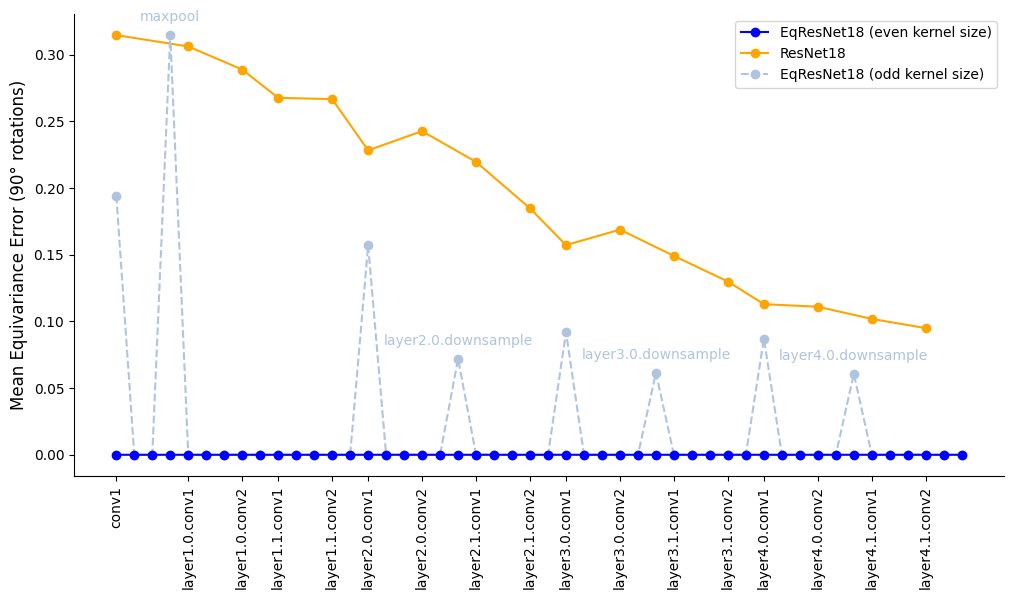

In [24]:
import matplotlib.pyplot as plt

x_ticks = [name for name in eq_even_errors_layers if 'conv' in name]
print(x_ticks)

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(eq_even_errors_layers, eq_even_errors_means, label='EqResNet18 (even kernel size)', marker='o', color='blue', zorder=10)
ax.plot(resnet_layers, resnet_layers_means, label='ResNet18', marker='o', color='orange')

ax.plot(eq_layers, eq_layers_means, label='EqResNet18 (odd kernel size)', marker='o', color='lightsteelblue', linestyle='--')

# Set x-ticks
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=90) 

# ticks for big error
for name, val in zip(eq_layers, eq_layers_means):
    if val > 0.05 and name not in x_ticks:
        ax.annotate(name, (name, val), textcoords="offset points", xytext=(0,10), ha='center', color='lightsteelblue')

#ax.annotate('maxpool', ('maxpool', eq_layers_dict['maxpool']), textcoords="offset points", xytext=(0,10), ha='center', color='lightsteelblue')


ax.legend()
ax.set_ylabel('Mean Equivariance Error (90° rotations)', fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

# Rotation invariance

In [12]:
# SimCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18)

acc_simclr, classifier_simclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8520891364902506


In [9]:
# EqCLR
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq)

acc_eqclr, classifier_eqclr = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8277158774373259


In [14]:
# EqCLR N=8
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_n8)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_n8)

acc_eqclr_n8, classifier_eqclr_n8 = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8537604456824512


In [15]:
# SimCLR without rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_resnet18_wo_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_resnet18_wo_rotation)

acc_simclr_wo_rotation, classifier_simclr_wo_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.866991643454039


In [16]:
# EqCLR with rotation
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_w_rotation)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_w_rotation)

acc_eqclr_w_rotation, classifier_eqclr_w_rotation = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8296657381615599


In [14]:
# wide resnet
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_w_res)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_w_res)

acc_w_res, classifier_w_res = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.8857938718662952


In [21]:
# EqCLR N=8 Gaussian blur
with torch.no_grad():
    X_train, y_train, Z_train = dataset_to_X_y(pmnist_train, model_eq_n8_gb)
    X_test, y_test, Z_test = dataset_to_X_y(pmnist_test, model_eq_n8_gb)

acc_eqclr_n8_gb, classifier_eqclr_n8_gb = lin_eval_rep(X_train, y_train, X_test, y_test, n_epochs=500, return_model=True)

Linear accuracy (Adam on precomputed representations): 0.86991643454039


In [10]:
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode
import random

models = {
    #"eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    "EqResnet18": (model_eq, classifier_eqclr),
    # "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    # "Resnet18": (model_resnet18, classifier_simclr),
    # "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
accuracies = {}

for model_name in models:
    model, classifier = models[model_name]
    accuracies[model_name] = {}

    with torch.no_grad():
        yhat = []
        y = []
        for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
            images, labels = batch

            rotated_images = []
            for img in images:
                angle = random.choice([0, 90, 180, 270])
                img_rot = TF.rotate(img, angle, interpolation=InterpolationMode.NEAREST, expand=False)
                rotated_images.append(img_rot)

            rotated_images = torch.stack(rotated_images)

            h, z = model(rotated_images.to(device))
            logits = classifier(h)

            yhat.append(logits.cpu().numpy())
            y.append(labels.cpu().numpy().ravel())

        yhat = np.vstack(yhat)
        y = np.hstack(y)

    acc = (yhat.argmax(axis=1) == y).mean()
    accuracies[model_name]['Lin. acc. rotated data'] = acc
    print(f"Linear accuracy for {model_name}: {acc}", flush=True)


Linear accuracy for EqResnet18: 0.8229805013927577


In [ ]:
import pandas as pd

accuracies['eqResnet18_N8']['Lin. acc. original data'] = acc_eqclr_n8
accuracies['EqResnet18']['Lin. acc. original data'] = acc_eqclr
accuracies['EqResnet18 with rotation']['Lin. acc. original data'] = acc_eqclr_w_rotation
accuracies['Resnet18']['Lin. acc. original data'] = acc_simclr
accuracies['Resnet18 without rotation']['Lin. acc. original data'] = acc_simclr_wo_rotation
accuracies_df = pd.DataFrame(accuracies).T
display(accuracies_df)

In [18]:
def rotate_90(x, angle):
    """Rotate a BCHW PyTorch tensor by 0/90/180/270 degrees without interpolation."""
    if angle == 0:
        return x
    elif angle == 90:
        return x.transpose(-1, -2).flip(-1)        # rotate 90° CCW
    elif angle == 180:
        return x.flip(-1).flip(-2)
    elif angle == 270:
        return x.transpose(-1, -2).flip(-2)        # rotate 90° CW
    else:
        raise ValueError("Angle must be 0, 90, 180, or 270")


In [22]:
import torchvision.transforms.functional as TF
import tensorflow as tf

models = {
    "eqResnet18_N8_gb": (model_eq_n8_gb, classifier_eqclr_n8_gb),
    #"eqResnet18_N8": (model_eq_n8, classifier_eqclr_n8),
    #"EqResnet18": (model_eq, classifier_eqclr),
    # "WideResnet18": (model_w_res, classifier_w_res),
    # "EqResnet18 with rotation": (model_eq_w_rotation, classifier_eqclr_w_rotation),
    # "Resnet18": (model_resnet18, classifier_simclr),
    # "Resnet18 without rotation": (model_resnet18_wo_rotation, classifier_simclr_wo_rotation),
}
consistencies = {}

for model_name in models:
    model, classifier = models[model_name]
    consistencies[model_name] = {}
    
    with torch.no_grad():
        y_hat = []
        y = []
        for angle in [0, 90, 180, 270]:
            yhat_angle = []
            y_angle = []
            for batch_idx, batch in enumerate(DataLoader(pmnist_test, batch_size=1024)):
                images, labels = batch

                rotated_images = []
                for img in images:
                    img_rot = TF.rotate(img, angle, expand=False)
                    # img_rot = rotate_90(img, angle)
                    rotated_images.append(img_rot)

                rotated_images = torch.stack(rotated_images)

                h, z = model(rotated_images.to(device))
                logits = classifier(h)

                yhat_angle.append(logits.cpu().numpy())
                y_angle.append(labels.cpu().numpy().ravel())

            yhat_angle = np.vstack(yhat_angle)
            y_angle = np.hstack(y_angle)

            y_hat.append(yhat_angle.argmax(axis=1))
            y = y_angle

        acc = (yhat_angle.argmax(axis=1) == y_angle).mean()
        #accuracies[model_name]['Lin. acc. rotated data'] = acc
        print(f"Linear accuracy for {model_name} - rotation {angle}: {acc}", flush=True)

        # # compute consistency
        # consistent_mask = (y_hat[0] == y_hat[1]) & \
        #               (y_hat[0] == y_hat[2]) & \
        #               (y_hat[0] == y_hat[3])

        # consistency_percentage = consistent_mask.mean() * 100
        # print(f"Percentage of samples predicted the same across all rotations: {consistency_percentage:.2f}%")
            
        y_hat = np.vstack(y_hat).T  # shape (n_samples, 4)
        num_unique_preds = np.array([len(np.unique(p)) for p in y_hat])

        # Now compute percentages
        total_samples = len(num_unique_preds)
        percentages = {
            'all_same': (num_unique_preds == 1).sum() / total_samples * 100,
            '1 different': (num_unique_preds == 2).sum() / total_samples * 100,
            '2 different': (num_unique_preds == 3).sum() / total_samples * 100,
            'all different': (num_unique_preds == 4).sum() / total_samples * 100
        }
        consistencies[model_name] = percentages

        # Print nicely
        for k, v in percentages.items():
            print(f"{k}: {v:.2f}%")

Linear accuracy for eqResnet18_N8_gb - rotation 270: 0.8720055710306407
all_same: 92.76%
1 different: 6.82%
2 different: 0.40%
all different: 0.01%


In [23]:
import pandas as pd

consistencies_df = pd.DataFrame(consistencies).T
display(consistencies_df)

,all_same,1 different,2 different,all different
eqResnet18_N8_gb,92.75766,6.824513,0.4039,0.013928


# t-SNE

In [21]:
list_h_eq = []
list_h_res = []
labels_list = []

test_loader = DataLoader(pmnist_test, batch_size=128, shuffle=False)


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        h_eq, _ = model_eq_n8(images)
        h_res, _ = model_resnet18(images) 

        list_h_eq.append(h_eq.cpu())
        list_h_res.append(h_res.cpu())
        labels_list.append(labels)

all_h_eq = torch.cat(list_h_eq, dim=0).numpy()
all_h_res = torch.cat(list_h_res, dim=0).numpy()
all_labels = torch.cat(labels_list, dim=0).numpy()

In [22]:
from openTSNE import TSNE

tsne_eq = TSNE()
eq_emb = tsne_eq.fit(all_h_eq)

tsne_res = TSNE()
res_emb = tsne_res.fit(all_h_res)

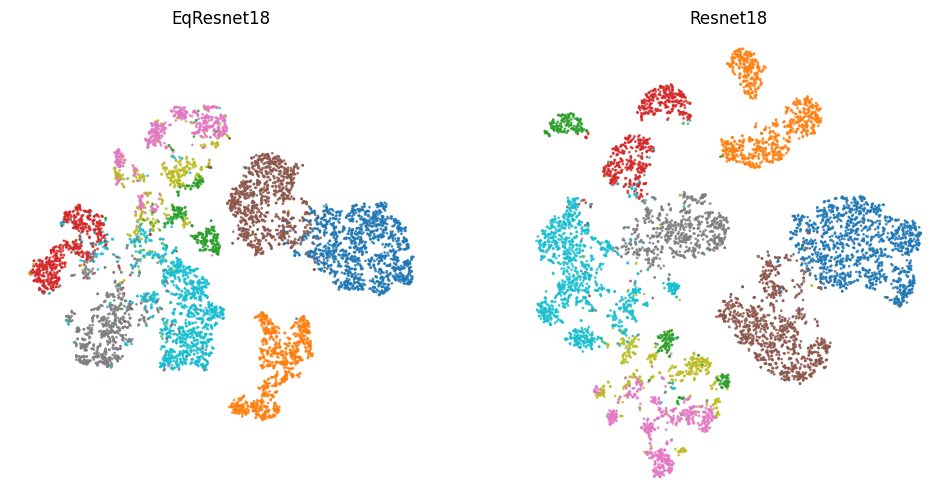

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# EqCLR plot
scatter_eq = ax[0].scatter(eq_emb[:, 0], eq_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[0].set_title('EqResnet18')

# SimCLR plot
scatter_res = ax[1].scatter(res_emb[:, 0], res_emb[:, 1], c=all_labels, cmap='tab10', s=1, alpha=0.75)
ax[1].set_title('Resnet18')

for a in ax:
    a.axis('off')
    a.axis('equal')
